<a href="https://colab.research.google.com/github/Pearlkakande/machinelearning/blob/main/models/models6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


MODEL TRAINING FOR GRAPH-BASED KNOWLEDGE DISTILLATION AND FEATURE LEARNING FOR BOOK RECOMMENDATIONS

Ten models are to be trained with model evaluation being handled by wandb

dataset= Eitanli/goodreads for the hugging face dataset library

SET UP

packages, dataset, wandb

In [20]:
# Install necessary packages (uncomment if needed)
!pip install datasets torch wandb sentence-transformers scikit-learn
!pip install torch-scatter torch-sparse torch-cluster torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData, DataLoader
from torch_geometric.nn import GCNConv, GATConv  # and other layers as needed
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import wandb
import numpy as np
import pandas as pd

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


WANDB

In [ ]:
# (Global W&B login is fine to do once)
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pearlkakande (pearlkakande-makerere-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Dataset Loading

In [21]:
# Load the dataset from Hugging Face
dataset = load_dataset("Eitanli/goodreads")["train"]  # assume 'train' split
df = pd.DataFrame(dataset)
print(df.columns.tolist())


Repo card metadata block was not found. Setting CardData to empty.


['Unnamed: 0', 'Book', 'Author', 'Description', 'Genres', 'Avg_Rating', 'Num_Ratings', 'URL']


GRAPH CONSTUCTION

Description embedding, spliting of dataset

the book, author and genre are nodes

edges show relationship and addding rating-based popularity as a node attribute or as edge weight

In [22]:
# Use a pre-trained sentence transformer to embed the book descriptions.
model_st = SentenceTransformer('all-MiniLM-L6-v2')
df['desc_emb'] = df['Description'].fillna("").apply(lambda x: model_st.encode(x))


# Split into train/test (e.g., 80/20 split by index for simplicity)
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

# Build a simple heterogeneous graph (using PyG's HeteroData):
def build_hetero_graph(df):
    data = HeteroData()

    # Create book nodes: use description embeddings as features.
    book_emb = np.stack(df['desc_emb'].values)
    data['book'].x = torch.tensor(book_emb, dtype=torch.float)

    # For authors and genres, create a mapping.
    authors = list(df['Author'].unique())
    genres = list(df['Genres'].unique())
    author2id = {a: i for i, a in enumerate(authors)}
    genre2id = {g: i for i, g in enumerate(genres)}

    # Create author nodes with one-hot features.
    data['author'].num_nodes = len(authors)
    data['author'].x = F.one_hot(torch.arange(len(authors)), num_classes=len(authors)).float()

    # Create genre nodes.
    data['genre'].num_nodes = len(genres)
    data['genre'].x = F.one_hot(torch.arange(len(genres)), num_classes=len(genres)).float()

    # Build edges: book -> author and book -> genre.
    book_ids = np.arange(len(df))
    author_ids = [author2id[a] for a in df['Author']]
    genre_ids = [genre2id[g] for g in df['Genres']]

    data['book', 'written_by', 'author'].edge_index = torch.tensor([book_ids, author_ids], dtype=torch.long)
    data['book', 'has_genre', 'genre'].edge_index = torch.tensor([book_ids, genre_ids], dtype=torch.long)

    # (Optional) Build book-to-book similarity edges based on cosine similarity between description embeddings:
    # For simplicity, here we add edges for pairs with similarity > 0.9.
    from sklearn.metrics.pairwise import cosine_similarity
    sim_matrix = cosine_similarity(book_emb)
    src, dst = np.where(sim_matrix > 0.9)
    # remove self-loops:
    mask = src != dst
    data['book', 'similar_to', 'book'].edge_index = torch.tensor([src[mask], dst[mask]], dtype=torch.long)

    # You can also include rating-based popularity as a node attribute or as edge weight.
    # For example, store ratings_count and average_rating in a separate tensor.
    #convert num ratings to int type for later manipulation
    df['Num_Ratings'] = df['Num_Ratings'].str.replace(',', '').astype(int)
    data['book'].ratings_count = torch.tensor(df['Num_Ratings'].values.astype(float), dtype=torch.float)
    data['book'].average_rating = torch.tensor(df['Avg_Rating'].values.astype(float), dtype=torch.float)

    return data

data = build_hetero_graph(train_df)  # build graph from training data

MODEL 1 LightGCN for Book Recommendation



Epoch 0: Loss=1151.8820, Acc=0.4813, Prec=0.0000, Rec=0.0000, F1=0.0000
Epoch 10: Loss=104.4055, Acc=0.5106, Prec=0.5054, Rec=1.0000, F1=0.6714
Epoch 20: Loss=117.1444, Acc=0.6120, Prec=0.5631, Rec=1.0000, F1=0.7205
      Model       Loss  Accuracy  Precision  Recall        F1
0  LightGCN  99.778412  0.712375    0.63482     1.0  0.776624
Confusion Matrix:
[[1699 2301]
 [   0 4000]]


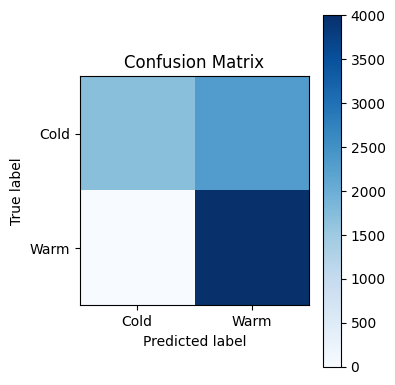

accuracy,▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
f1,▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
loss,█▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
precision,▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████
recall,▁█████████████████████████████
Model,LightGCN
accuracy,0.71237
epoch,29
f1,0.77662
loss,99.77841


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch import nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import numpy as np

# Initialize wandb before training the model
wandb.init(project="book-model",    # Replace with your project name
           entity="pearlkakande-makerere-university",       # Replace with your wandb username or team name
           config={"model": "LightGCN", "epochs": 30, "learning_rate": 0.01})

# Assume wandb.login() was called in an earlier cell

class LightGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers=2):
        super(LightGCN, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        # Final linear layer: note we later concatenate popularity signal so input dims change.
        # Here we assume hidden_channels remains unchanged; adjust if needed.
        self.lin = nn.Linear(hidden_channels + 1, 2)  # binary classification: warm vs cold

    def forward(self, data):
        # Use only 'book' nodes for prediction.
        x = data['book'].x  # initial features from description embeddings
        for conv in self.convs:
            x = conv(x, data['book', 'similar_to', 'book'].edge_index)
            x = F.relu(x)
        # Concatenate popularity signal (ratings_count)
        ratings = data['book'].ratings_count.unsqueeze(1)
        x_cat = torch.cat([x, ratings], dim=1)
        out = self.lin(x_cat)
        return out, x_cat  # also return latent embedding for potential distillation

# Define warm items based on ratings_count > threshold.
threshold = train_df['Num_Ratings'].median()
labels = (train_df['Num_Ratings'] > threshold).astype(int).values
labels = torch.tensor(labels, dtype=torch.long)

# Set device and create model instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = LightGCN(in_channels=data['book'].x.size(1), hidden_channels=64, num_layers=2).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)

# Move data to device
data['book'].x = data['book'].x.to(device)
data['book', 'similar_to', 'book'].edge_index = data['book', 'similar_to', 'book'].edge_index.to(device)
data['book'].ratings_count = data['book'].ratings_count.to(device)
labels = labels.to(device)

# Training loop for 30 epochs
num_epochs = 30
model1.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    out, _ = model1(data)
    loss = F.cross_entropy(out, labels)
    loss.backward()
    optimizer.step()

    # Evaluate on training data (for demo purposes)
    preds = out.argmax(dim=1).cpu().numpy()
    truelabels = labels.cpu().numpy()
    acc = accuracy_score(truelabels, preds)
    prec = precision_score(truelabels, preds, zero_division=0)
    rec = recall_score(truelabels, preds, zero_division=0)
    f1 = f1_score(truelabels, preds, zero_division=0)

    wandb.log({
        "Model": "LightGCN",
        "epoch": epoch,
        "loss": loss.item(),
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss={loss.item():.4f}, Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")

# After training, create a summary table for the training set.
results = {"Model": "LightGCN", "Loss": loss.item(), "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}
print(pd.DataFrame([results]))

# Compute confusion matrix on training data
cm = confusion_matrix(truelabels, preds)
print("Confusion Matrix:")
print(cm)

# Optionally, log the confusion matrix as a plot to wandb:
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Cold", "Warm"])
plt.yticks(tick_marks, ["Cold", "Warm"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

# Finish the wandb run
wandb.finish()


MODEL 2 Graph Attention Network (GAT) for Books


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch import nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

# Initialize wandb before training the model
wandb.init(project="book-model",    # Replace with your project name
           entity="pearlkakande-makerere-university",     # Replace with your wandb username or team name
           config={"model": "GATBook", "epochs": 30, "learning_rate": 0.01})

class GATBook(nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=2, num_layers=2):
        super(GATBook, self).__init__()
        self.gat_layers = nn.ModuleList()
        self.gat_layers.append(GATConv(in_channels, hidden_channels, heads=heads))
        for _ in range(num_layers - 1):
            self.gat_layers.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads))
        self.lin = nn.Linear(hidden_channels * heads + 1, 2)  # add ratings_count

    def forward(self, data):
        x = data['book'].x
        for gat in self.gat_layers:
            x = gat(x, data['book', 'similar_to', 'book'].edge_index)
            x = F.elu(x)
        ratings = data['book'].ratings_count.unsqueeze(1)
        x = torch.cat([x, ratings], dim=1)
        out = self.lin(x)
        return out

# Define warm items based on ratings_count > threshold.
threshold = train_df['Num_Ratings'].median()
labels = (train_df['Num_Ratings'] > threshold).astype(int).values
labels = torch.tensor(labels, dtype=torch.long)

# Set device and create model instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = GATBook(in_channels=data['book'].x.size(1), hidden_channels=32, heads=2).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.005)

# Move data to device
data['book'].x = data['book'].x.to(device)
data['book', 'similar_to', 'book'].edge_index = data['book', 'similar_to', 'book'].edge_index.to(device)
data['book'].ratings_count = data['book'].ratings_count.to(device)
labels = labels.to(device)

# Training loop for 30 epochs
num_epochs = 30
model2.train()
for epoch in range(num_epochs):
    optimizer2.zero_grad()
    out = model2(data)
    loss = F.cross_entropy(out, labels)
    loss.backward()
    optimizer2.step()

    # Evaluate on training data (for demo purposes)
    preds = out.argmax(dim=1).cpu().numpy()
    truelabels = labels.cpu().numpy()
    acc = accuracy_score(truelabels, preds)
    prec = precision_score(truelabels, preds, zero_division=0)
    rec = recall_score(truelabels, preds, zero_division=0)
    f1 = f1_score(truelabels, preds, zero_division=0)

    # Compute confusion matrix
    cm = confusion_matrix(truelabels, preds)

    # Log metrics and confusion matrix to wandb
    wandb.log({
        "Model": "GATBook",
        "epoch": epoch,
        "loss": loss.item(),
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                        y_true=truelabels,
                                                        preds=preds,
                                                        class_names=["Cold", "Warm"])
    })

    if epoch % 10 == 0:
        print(f"GAT Epoch {epoch}: Loss={loss.item():.4f}, Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")

# After training, create a summary table for the training set.
results2 = {"Model": "GATBook", "Loss": loss.item(), "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}
print(pd.DataFrame([results2]))

# Finish the wandb run
wandb.finish()


GAT Epoch 0: Loss=66.6111, Acc=0.4999, Prec=0.0000, Rec=0.0000, F1=0.0000
GAT Epoch 10: Loss=60.7780, Acc=0.6148, Prec=0.5648, Rec=1.0000, F1=0.7219
GAT Epoch 20: Loss=63.3041, Acc=0.7324, Prec=0.6514, Rec=1.0000, F1=0.7889
     Model       Loss  Accuracy  Precision  Recall        F1
0  GATBook  47.351501   0.79275   0.706964     1.0  0.828329


accuracy,▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
f1,▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
loss,█▁▂▄▄▅▆▆▇▇▇▇█████████▇▇▇▇▇▆▆▆▅
precision,▁▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
recall,▁█████████████████████████████
Model,GATBook
accuracy,0.79275
epoch,29
f1,0.82833
loss,47.3515


MODEL 3

Teacher Epoch 0: Loss=16.6825
Teacher Epoch 10: Loss=1.5315
Teacher Epoch 20: Loss=0.9638
Student Epoch 0: Total Loss=50.0902
Student Epoch 10: Total Loss=18.2100
Student Epoch 20: Total Loss=37.1157
           Model       Loss  Accuracy  Precision  Recall       F1
0  PGD (Student)  37.840187    0.7835   0.697837     1.0  0.82203
Confusion Matrix:
[[2268 1732]
 [   0 4000]]


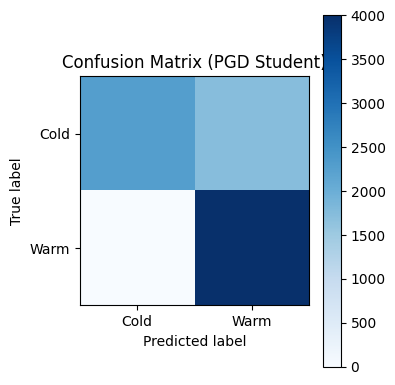

accuracy,▁▁▂▄▇▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
class_loss,▂▂▁▁▁█▃▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂
distill_loss,██▇▇▆▅▄▃▂▂▁▁▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂
epoch,▁▁▁▂▂▃▃▃▄▄▅▅▅▅▅▇▇▇▇█▁▁▁▂▂▃▃▃▃▃▅▅▅▅▆▆▇▇▇█
f1,▇▇▇▇█▁▁███████████████████████
loss,██▇▇▆▅▄▄▃▂▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
loss_total,▂▂▁▁▁█▃▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂
precision,▆▆▆▇█▁▁██▇████████████████████
recall,█████▁▁███████████████████████
Model,PGD_Student
accuracy,0.7835


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch import nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import numpy as np

# Initialize wandb before training the model
wandb.init(project="book-model",    # Replace with your project name
           entity="pearlkakande-makerere-university",  # your wandb username or team name
           config={"model": "PGD", "epochs": 30, "learning_rate": 0.01})

# Define Teacher and Student models for PGD
class TeacherGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(TeacherGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x = data['book'].x
        x = F.relu(self.conv1(x, data['book', 'similar_to', 'book'].edge_index))
        x = self.conv2(x, data['book', 'similar_to', 'book'].edge_index)
        return x

class StudentGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(StudentGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels + 1, 2)  # +1 for ratings_count feature

    def forward(self, data):
        x = data['book'].x
        x = F.relu(self.conv1(x, data['book', 'similar_to', 'book'].edge_index))
        x = self.conv2(x, data['book', 'similar_to', 'book'].edge_index)
        ratings = data['book'].ratings_count.unsqueeze(1)
        x_cat = torch.cat([x, ratings], dim=1)
        out = self.lin(x_cat)
        return out, x

# Define warm items based on ratings_count > threshold.
# Here we use 'Num_Ratings' from train_df for labeling and 'average_rating' as teacher target.
threshold = train_df['Num_Ratings'].median()
labels = (train_df['Num_Ratings'] > threshold).astype(int).values
labels = torch.tensor(labels, dtype=torch.long)

# Set device and create model instances
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher = TeacherGCN(in_channels=data['book'].x.size(1), hidden_channels=64).to(device)
student = StudentGCN(in_channels=data['book'].x.size(1), hidden_channels=64).to(device)

optimizer_teacher = torch.optim.Adam(teacher.parameters(), lr=0.01)
optimizer_student = torch.optim.Adam(student.parameters(), lr=0.01)

# Move data and labels to device
data['book'].x = data['book'].x.to(device)
data['book', 'similar_to', 'book'].edge_index = data['book', 'similar_to', 'book'].edge_index.to(device)
data['book'].ratings_count = data['book'].ratings_count.to(device)
data['book'].average_rating = data['book'].average_rating.to(device)  # used as target for teacher
labels = labels.to(device)

num_epochs = 30

# --- Teacher Training ---
teacher.train()
for epoch in range(num_epochs):
    optimizer_teacher.zero_grad()
    teacher_emb = teacher(data)
    # Use a regression loss to predict average_rating as a proxy for CF signals.
    target = data['book'].average_rating.unsqueeze(1)
    # Here we take the mean over the embedding dimensions as a simple proxy.
    loss_teacher = F.mse_loss(teacher_emb.mean(dim=1, keepdim=True), target)
    loss_teacher.backward()
    optimizer_teacher.step()
    wandb.log({"Model": "PGD_Teacher", "epoch": epoch, "loss": loss_teacher.item()})
    if epoch % 10 == 0:
        print(f"Teacher Epoch {epoch}: Loss={loss_teacher.item():.4f}")

# Freeze teacher parameters
for param in teacher.parameters():
    param.requires_grad = False

# --- Student Training with Knowledge Distillation ---
student.train()
alpha = 0.7  # weight for distillation loss; 0.3 for ground truth classification
for epoch in range(num_epochs):
    optimizer_student.zero_grad()
    out_student, student_emb = student(data)
    with torch.no_grad():
        teacher_emb = teacher(data)
    # Distillation loss: MSE between student and teacher embeddings.
    loss_distill = F.mse_loss(student_emb, teacher_emb)
    # Classification loss: cross-entropy loss against warm/cold labels.
    loss_class = F.cross_entropy(out_student, labels)
    loss_total = alpha * loss_distill + (1 - alpha) * loss_class
    loss_total.backward()
    optimizer_student.step()

    preds = out_student.argmax(dim=1).cpu().numpy()
    truelabels = labels.cpu().numpy()
    acc = accuracy_score(truelabels, preds)
    prec = precision_score(truelabels, preds, zero_division=0)
    rec = recall_score(truelabels, preds, zero_division=0)
    f1 = f1_score(truelabels, preds, zero_division=0)

    wandb.log({"Model": "PGD_Student", "epoch": epoch, "loss_total": loss_total.item(),
               "distill_loss": loss_distill.item(), "class_loss": loss_class.item(),
               "accuracy": acc, "precision": prec, "recall": rec, "f1": f1})
    if epoch % 10 == 0:
        print(f"Student Epoch {epoch}: Total Loss={loss_total.item():.4f}")

results3 = {"Model": "PGD (Student)", "Loss": loss_total.item(), "Accuracy": acc,
            "Precision": prec, "Recall": rec, "F1": f1}
print(pd.DataFrame([results3]))

# Compute confusion matrix on training data using final predictions
cm = confusion_matrix(truelabels, preds)
print("Confusion Matrix:")
print(cm)

# Plot and log the confusion matrix to wandb
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (PGD Student)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Cold", "Warm"])
plt.yticks(tick_marks, ["Cold", "Warm"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

# Finish the wandb run
wandb.finish()


MODEL 4 Hybrid Graph-based Model for Cold-Start Recommendations

Hybrid Epoch 0: Loss=55.8003
Hybrid Epoch 10: Loss=41.4788
Hybrid Epoch 20: Loss=73.1341
Confusion Matrix:
[[1968 2032]
 [   0 4000]]


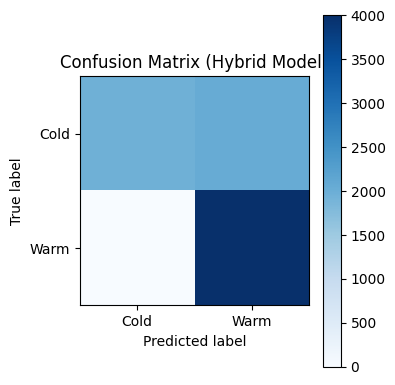

    Model       Loss  Accuracy  Precision  Recall        F1
0  Hybrid  73.800804     0.746    0.66313     1.0  0.797448


accuracy,▁▁▂▅▁▁▅▅▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
f1,▇▇▇▇▁▁█▇▇▇▇▇▇▇▇▇▇█████████████
loss,▂▁▁▁█▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
precision,▆▆▇▇▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
recall,████▁▁████████████████████████
Model,Hybrid
accuracy,0.746
epoch,29
f1,0.79745
loss,73.8008


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch import nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import numpy as np

# Initialize wandb before training the model
wandb.init(project="book-model",
           entity="pearlkakande-makerere-university",
           config={"model": "Hybrid", "epochs": 30, "learning_rate": 0.005})

class HybridModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, text_dim):
        super(HybridModel, self).__init__()
        # Graph branch
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        # Text branch
        self.fc_text = nn.Linear(text_dim, hidden_channels)
        # Fusion and final classifier (with popularity)
        self.fc_final = nn.Linear(hidden_channels * 2 + 1, 2)

    def forward(self, data):
        # Graph branch
        x_graph = F.relu(self.gcn1(data['book'].x, data['book', 'similar_to', 'book'].edge_index))
        x_graph = self.gcn2(x_graph, data['book', 'similar_to', 'book'].edge_index)
        # Text branch
        x_text = F.relu(self.fc_text(data['book'].x))
        # Combine graph, text, and popularity features
        ratings = data['book'].ratings_count.unsqueeze(1)
        x_comb = torch.cat([x_graph, x_text, ratings], dim=1)
        out = self.fc_final(x_comb)
        return out

# Define warm items based on ratings_count > threshold.
threshold = train_df['Num_Ratings'].median()
labels = (train_df['Num_Ratings'] > threshold).astype(int).values
labels = torch.tensor(labels, dtype=torch.long)

# Set device and create model instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4 = HybridModel(in_channels=data['book'].x.size(1), hidden_channels=32, text_dim=data['book'].x.size(1)).to(device)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.005)

# Move data to device
data['book'].x = data['book'].x.to(device)
data['book', 'similar_to', 'book'].edge_index = data['book', 'similar_to', 'book'].edge_index.to(device)
data['book'].ratings_count = data['book'].ratings_count.to(device)
labels = labels.to(device)

# Training loop for 30 epochs
num_epochs = 30
model4.train()
for epoch in range(num_epochs):
    optimizer4.zero_grad()
    out = model4(data)
    loss = F.cross_entropy(out, labels)
    loss.backward()
    optimizer4.step()

    # Evaluate on training data
    preds = out.argmax(dim=1).cpu().numpy()
    truelabels = labels.cpu().numpy()
    acc = accuracy_score(truelabels, preds)
    prec = precision_score(truelabels, preds, zero_division=0)
    rec = recall_score(truelabels, preds, zero_division=0)
    f1 = f1_score(truelabels, preds, zero_division=0)

    wandb.log({
        "Model": "Hybrid",
        "epoch": epoch,
        "loss": loss.item(),
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

    if epoch % 10 == 0:
        print(f"Hybrid Epoch {epoch}: Loss={loss.item():.4f}")

# Compute confusion matrix
cm = confusion_matrix(truelabels, preds)
print("Confusion Matrix:")
print(cm)

# Plot and log the confusion matrix as an image to wandb
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Hybrid Model)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Cold", "Warm"])
plt.yticks(tick_marks, ["Cold", "Warm"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

results4 = {"Model": "Hybrid", "Loss": loss.item(), "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}
print(pd.DataFrame([results4]))

# Finish the wandb run
wandb.finish()


MODEL 5 Knowledge Distillation with ALDI Framework

<ipython-input-18-23592702bdc8>:66: UserWarning: Using a target size (torch.Size([8000, 1])) that is different to the input size (torch.Size([8000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_teacher = F.mse_loss(emb.mean(dim=1), target)


ALDI Teacher Epoch 0: Loss=16.6653
ALDI Teacher Epoch 10: Loss=11.1444
ALDI Teacher Epoch 20: Loss=6.9988
ALDI Student Epoch 0: Total Loss=479.8659
ALDI Student Epoch 10: Total Loss=41.5132
ALDI Student Epoch 20: Total Loss=42.9137
            Model       Loss  Accuracy  Precision  Recall        F1
0  ALDI (Student)  33.467648  0.783375   0.697715     1.0  0.821946
Confusion Matrix:
[[2267 1733]
 [   0 4000]]


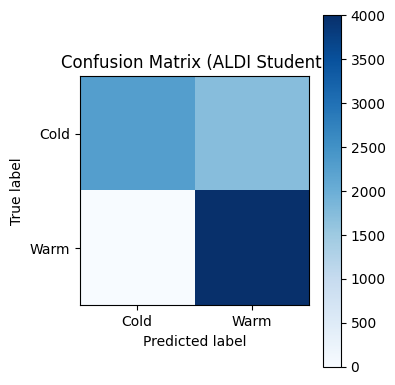

accuracy,▁▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
class_loss,█▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
distill_loss,██▇▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇▇█▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▇▇▇█
f1,▁▇▇▇▇▇▇▇▇▇▇▇██████████████████
loss,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
loss_total,█▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
precision,▁▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
recall,▁█████████████████████████████
Model,ALDI_Student
accuracy,0.78338


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch import nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import numpy as np

# Initialize wandb before training the model
wandb.init(project="book-model",    # Replace with your project name
           entity="pearlkakande-makerere-university",  # your wandb username or team name
           config={"model": "ALDI", "epochs": 30, "learning_rate": 0.01})

class ALDITeacher(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(ALDITeacher, self).__init__()
        self.conv = GCNConv(in_channels, hidden_channels)

    def forward(self, data):
        x = self.conv(data['book'].x, data['book', 'similar_to', 'book'].edge_index)
        return x

class ALDIStudent(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(ALDIStudent, self).__init__()
        self.conv = GCNConv(in_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels + 1, 2)  # +1 for ratings_count

    def forward(self, data):
        x = self.conv(data['book'].x, data['book', 'similar_to', 'book'].edge_index)
        ratings = data['book'].ratings_count.unsqueeze(1)
        x_cat = torch.cat([x, ratings], dim=1)
        out = self.lin(x_cat)
        return out, x

# Create model instances
teacher_aldi = ALDITeacher(in_channels=data['book'].x.size(1), hidden_channels=64).to(device)
student_aldi = ALDIStudent(in_channels=data['book'].x.size(1), hidden_channels=64).to(device)

optimizer_teacher_aldi = torch.optim.Adam(teacher_aldi.parameters(), lr=0.01)
optimizer_student_aldi = torch.optim.Adam(student_aldi.parameters(), lr=0.01)

# Define warm items based on ratings_count > threshold.
threshold = train_df['Num_Ratings'].median()
labels = (train_df['Num_Ratings'] > threshold).astype(int).values
labels = torch.tensor(labels, dtype=torch.long)

# Move data and labels to device
data['book'].x = data['book'].x.to(device)
data['book', 'similar_to', 'book'].edge_index = data['book', 'similar_to', 'book'].edge_index.to(device)
data['book'].ratings_count = data['book'].ratings_count.to(device)
data['book'].average_rating = data['book'].average_rating.to(device)
labels = labels.to(device)

num_epochs = 30

# --- Teacher Training ---
teacher_aldi.train()
for epoch in range(num_epochs):
    optimizer_teacher_aldi.zero_grad()
    emb = teacher_aldi(data)
    # Use MSE loss to predict the average rating as a proxy for CF signals.
    target = data['book'].average_rating.unsqueeze(1)
    loss_teacher = F.mse_loss(emb.mean(dim=1), target)
    loss_teacher.backward()
    optimizer_teacher_aldi.step()
    wandb.log({"Model": "ALDI_Teacher", "epoch": epoch, "loss": loss_teacher.item()})
    if epoch % 10 == 0:
        print(f"ALDI Teacher Epoch {epoch}: Loss={loss_teacher.item():.4f}")

# Freeze teacher parameters
for param in teacher_aldi.parameters():
    param.requires_grad = False

# --- Student Training with Knowledge Distillation ---
student_aldi.train()
alpha = 0.6  # weight for distillation loss; 0.4 for ground truth classification
for epoch in range(num_epochs):
    optimizer_student_aldi.zero_grad()
    out_student, emb_student = student_aldi(data)
    with torch.no_grad():
        teacher_emb = teacher_aldi(data)
    # Distillation loss: MSE between student and teacher embeddings.
    loss_distill = F.mse_loss(emb_student, teacher_emb)
    # Classification loss: cross-entropy loss against warm/cold labels.
    loss_class = F.cross_entropy(out_student, labels)
    loss_total = alpha * loss_distill + (1 - alpha) * loss_class
    loss_total.backward()
    optimizer_student_aldi.step()

    preds = out_student.argmax(dim=1).cpu().numpy()
    truelabels = labels.cpu().numpy()
    acc = accuracy_score(truelabels, preds)
    prec = precision_score(truelabels, preds, zero_division=0)
    rec = recall_score(truelabels, preds, zero_division=0)
    f1 = f1_score(truelabels, preds, zero_division=0)

    wandb.log({"Model": "ALDI_Student", "epoch": epoch, "loss_total": loss_total.item(),
               "distill_loss": loss_distill.item(), "class_loss": loss_class.item(),
               "accuracy": acc, "precision": prec, "recall": rec, "f1": f1})

    if epoch % 10 == 0:
        print(f"ALDI Student Epoch {epoch}: Total Loss={loss_total.item():.4f}")

results5 = {"Model": "ALDI (Student)", "Loss": loss_total.item(), "Accuracy": acc,
            "Precision": prec, "Recall": rec, "F1": f1}
print(pd.DataFrame([results5]))

# Compute confusion matrix on training data
cm = confusion_matrix(truelabels, preds)
print("Confusion Matrix:")
print(cm)

# Plot and log the confusion matrix as an image to wandb
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (ALDI Student)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Cold", "Warm"])
plt.yticks(tick_marks, ["Cold", "Warm"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

# Finish the wandb run
wandb.finish()


MODEL 6 Meta-Learning on Knowledge Graph (MetaKG)

MetaKG Epoch 0: Loss=105.3194, Acc=0.5320
MetaKG Epoch 10: Loss=13.1248, Acc=0.7520
MetaKG Epoch 20: Loss=33.9277, Acc=0.7640
Confusion Matrix:
[[3819 3710]
 [ 237 7234]]


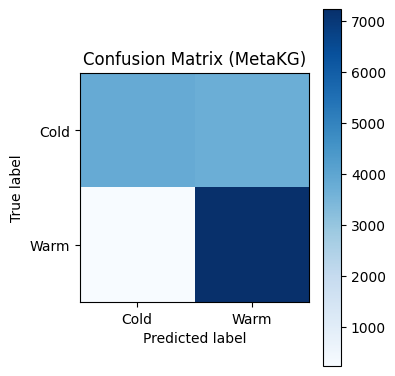

    Model       Loss
0  MetaKG  14.582858


accuracy,▁▁▁▃▃▃▆▁█▅▅▄▆▅▅▄▅▅▅▅▅▅▆▆▇▇▆▇▇▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
f1,▆▆▆▇▆▇▇▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇███
loss,▃▃▃▂▂▂▁█▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁
precision,▅▅▅▆▆▆▇▁█▇▇▆▇▇▇▆▇▆▇▆▇▇▇▇▇▇▇▇▇█
recall,███████▁██████████████████████
Model,MetaKG
accuracy,0.872
epoch,29
f1,0.8853
loss,14.58286


In [23]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch import nn
from torch_geometric.utils import subgraph
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import numpy as np

# Initialize wandb before training the model
wandb.init(project="book-model",    # Replace with your project name
           entity="pearlkakande-makerere-university",  # Replace with your wandb username or team name
           config={"model": "MetaKG", "epochs": 30, "learning_rate": 0.01})

# Define warm items based on ratings_count > threshold.
threshold = train_df['Num_Ratings'].median()
labels = (train_df['Num_Ratings'] > threshold).astype(int).values
labels = torch.tensor(labels, dtype=torch.long)

class MetaGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(MetaGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels + 1, 2)

    def forward(self, data):
        x = F.relu(self.conv1(data['book'].x, data['book', 'similar_to', 'book'].edge_index))
        x = self.conv2(x, data['book', 'similar_to', 'book'].edge_index)
        ratings = data['book'].ratings_count.unsqueeze(1)
        x_cat = torch.cat([x, ratings], dim=1)
        out = self.lin(x_cat)
        return out, x

# Sampling function for meta-learning tasks with proper edge re-indexing
def sample_task(data, labels, task_size=100):
    idx = torch.randperm(data['book'].x.size(0))[:task_size]
    task_data = data.clone()
    # Subset node features and ratings
    task_data['book'].x = data['book'].x[idx]
    task_data['book'].ratings_count = data['book'].ratings_count[idx]
    # Adjust edge indices for the sampled subgraph using subgraph utility
    orig_edge_index = data['book', 'similar_to', 'book'].edge_index
    new_edge_index, _ = subgraph(idx, orig_edge_index, relabel_nodes=True, num_nodes=data['book'].x.size(0))
    task_data['book', 'similar_to', 'book'].edge_index = new_edge_index
    return task_data, labels[idx]

# Set device and create model instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
meta_model = MetaGNN(in_channels=data['book'].x.size(1), hidden_channels=64).to(device)
meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=0.005)

# Move data and labels to device
data['book'].x = data['book'].x.to(device)
data['book', 'similar_to', 'book'].edge_index = data['book', 'similar_to', 'book'].edge_index.to(device)
data['book'].ratings_count = data['book'].ratings_count.to(device)
labels = labels.to(device)

meta_epochs = 30
meta_tasks = 5  # number of tasks per epoch

meta_model.train()
all_preds, all_labels = [], []
for epoch in range(meta_epochs):
    meta_loss = 0
    epoch_preds, epoch_labels = [], []

    for _ in range(meta_tasks):
        task_data, task_labels = sample_task(data, labels, task_size=100)
        task_data['book'].x = task_data['book'].x.to(device)
        task_data['book', 'similar_to', 'book'].edge_index = task_data['book', 'similar_to', 'book'].edge_index.to(device)
        task_data['book'].ratings_count = task_data['book'].ratings_count.to(device)
        task_labels = task_labels.to(device)

        out, _ = meta_model(task_data)
        loss = F.cross_entropy(out, task_labels)
        meta_loss += loss

        preds = out.argmax(dim=1).cpu().numpy()
        true_labels = task_labels.cpu().numpy()
        epoch_preds.extend(preds)
        epoch_labels.extend(true_labels)

    meta_loss /= meta_tasks
    meta_optimizer.zero_grad()
    meta_loss.backward()
    meta_optimizer.step()

    # Compute metrics for the current epoch
    acc = accuracy_score(epoch_labels, epoch_preds)
    prec = precision_score(epoch_labels, epoch_preds, zero_division=0)
    rec = recall_score(epoch_labels, epoch_preds, zero_division=0)
    f1 = f1_score(epoch_labels, epoch_preds, zero_division=0)

    wandb.log({"Model": "MetaKG", "epoch": epoch, "loss": meta_loss.item(),
               "accuracy": acc, "precision": prec, "recall": rec, "f1": f1})

    if epoch % 10 == 0:
        print(f"MetaKG Epoch {epoch}: Loss={meta_loss.item():.4f}, Acc={acc:.4f}")

    all_preds.extend(epoch_preds)
    all_labels.extend(epoch_labels)

# Compute confusion matrix on training data (across all tasks)
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Plot and log the confusion matrix as an image to wandb
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (MetaKG)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Cold", "Warm"])
plt.yticks(tick_marks, ["Cold", "Warm"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

results6 = {"Model": "MetaKG", "Loss": meta_loss.item()}
print(pd.DataFrame([results6]))

wandb.finish()


MODEL 7Graph Neural Network with Pseudo-Labelling over Knowledge Graph